In [2]:
import importlib
import utilities
import crypto_market_cap 
import visualisation
importlib.reload(utilities)
importlib.reload(crypto_market_cap)
importlib.reload(visualisation)
from visualisation import plot_multiline_chart
from utilities import TimeSeries
import torch as t 
from technical_indicators import calculate_rolling_mean, calculate_adx, calculate_bollinger_bands

In [3]:
from crypto_market_cap import get_crypto_market_cap_weights
market_data = get_crypto_market_cap_weights()
market_data['Symbol'] = market_data['Symbol']+'-USD'
weights_vector_all = market_data['Weight'].to_numpy()
market_data_smart_contracts = market_data.copy()
market_data_smart_contracts = market_data_smart_contracts[market_data_smart_contracts['Type']=='Smart Contract Platform']
weights_vector_smart_contracts = market_data_smart_contracts['Weight'].to_numpy()
market_data_coins = market_data.copy()
market_data_coins = market_data_coins[market_data_coins['Type']!='Smart Contract Platform']
weights_vector_coins = market_data_coins['Weight'].to_numpy()

In [4]:
from crypto_market_cap import get_crypto_market_cap_weights
market_data = get_crypto_market_cap_weights()
market_data['Symbol'] = market_data['Symbol']+'-USD'
market_data_time_series = [TimeSeries(symbol, date="2022-01-01").construct_returns().dropna() for symbol in market_data['Symbol']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [12]:
return_matrix_all = t.stack([t.Tensor(ts.data['Returns'].to_numpy()) for ts in market_data_time_series])
market_returns_all = t.tensor(market_data['Weight'],dtype=t.float).T @ return_matrix_all

return_matrix_smart_contracts = t.stack([t.Tensor(ts.data['Returns'].to_numpy()) for ts in market_data_time_series if ts.ticker in market_data_smart_contracts['Symbol'].to_numpy()])
market_returns_smart_contracts = t.tensor(weights_vector_smart_contracts,dtype=t.float).T @ return_matrix_smart_contracts

return_matrix_coins = t.stack([t.Tensor(ts.data['Returns'].to_numpy()) for ts in market_data_time_series if ts.ticker in market_data_coins['Symbol'].to_numpy()])
market_returns_coins = t.tensor(weights_vector_coins,dtype=t.float).T @ return_matrix_coins

In [13]:
from collections import namedtuple
import scipy
def get_rolling_betas (market_returns: t.Tensor, asset_returns: t.Tensor, window: int):
    beta_tuple = namedtuple('Beta', ['slope','intercept','p_value'])
    if len(market_returns.shape) != len(asset_returns.shape):
        raise ValueError("Market and asset returns must have the same number of dimensions")
    rolling_betas_temp = []
    for i in range(asset_returns.shape[0]):
        beta = t.cov(t.stack((asset_returns[i:i+window], market_returns[i:i+window])))[0,1]/t.var(market_returns[i:i+window])
        intercept = t.mean(asset_returns[i:i+window]) - beta*t.mean(market_returns[i:i+window])
        residuals = asset_returns[i:i+window] - (beta*market_returns[i:i+window] + intercept)
        standard_error = t.std(residuals)/t.std(market_returns[i:i+window])    
        t_value = beta / standard_error
        degrees_of_freedom = window - 2
        p_value = 2 * (1 - scipy.stats.t.cdf(abs(t_value), degrees_of_freedom))
        rolling_betas_temp.append(beta_tuple(beta, intercept, p_value))
        if i == len(asset_returns)-window:
            break
    rolling_betas = t.stack([x.slope for x in rolling_betas_temp])
    intercept = t.stack([x.intercept for x in rolling_betas_temp])
    p_value = t.stack([t.Tensor([x.p_value]) for x in rolling_betas_temp])
    return beta_tuple(rolling_betas[~rolling_betas.isnan()], intercept, p_value)

In [14]:
TICKERS = ['ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LINK-USD', 'TRX-USD']
time_series = [TimeSeries(symbol, date="2022-01-01").construct_returns().dropna() for symbol in TICKERS]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
rolling_betas_all_60 = {ticker: get_rolling_betas(market_returns_all, t.Tensor(ts.data['Returns'].to_numpy()), 60) for ts, ticker in zip(time_series, TICKERS)}

<module 'matplotlib.pyplot' from 'c:\\Users\\kumar\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

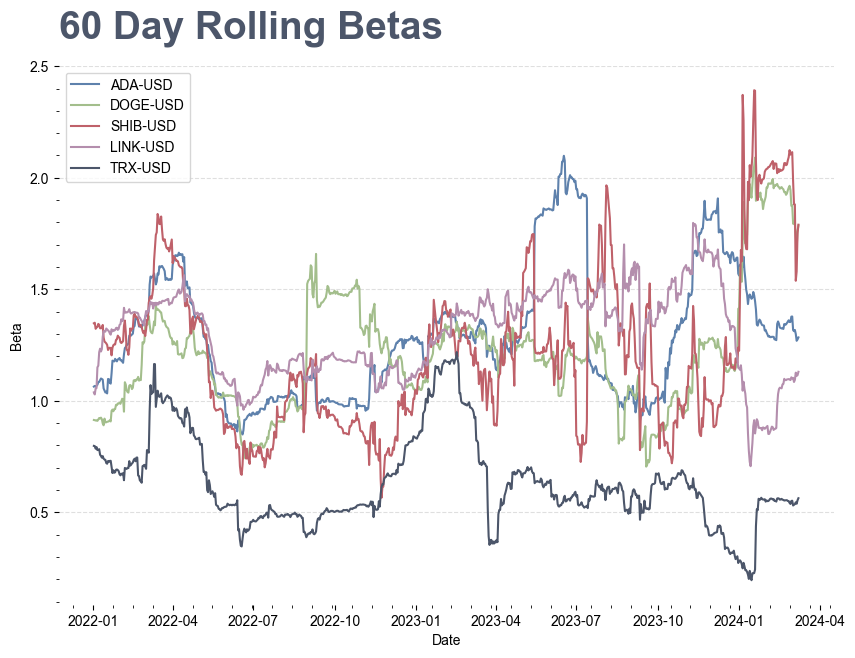

In [16]:
dates = time_series[0].data['Date']
plot_multiline_chart([(dates[:-59], rb.slope, f"{ticker}") for ticker, rb in rolling_betas_all_60.items()], title="60 Day Rolling Betas", x_label="Date", y_label="Beta")

<module 'matplotlib.pyplot' from 'c:\\Users\\kumar\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

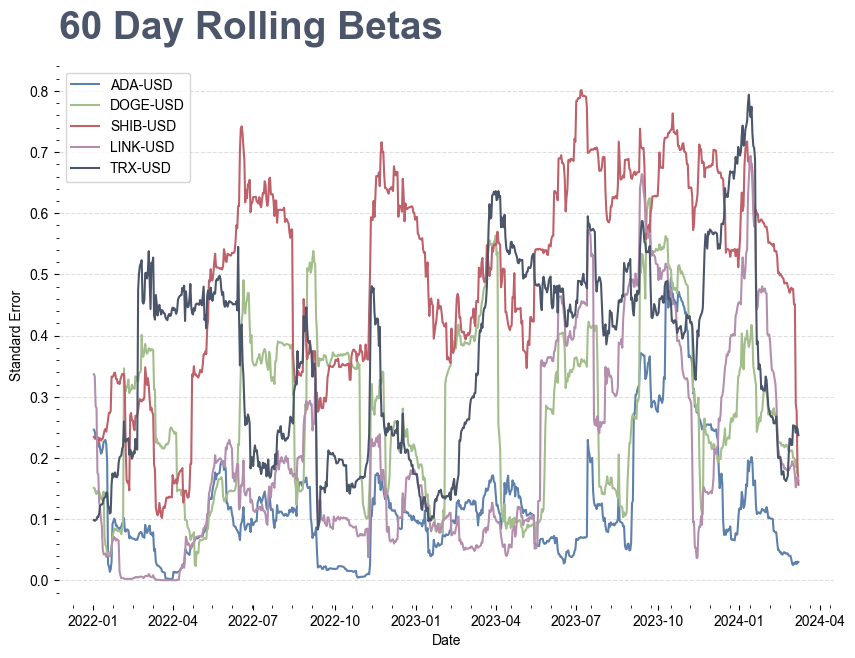

In [18]:
plot_multiline_chart([(dates[:-59], rb.p_value, f"{ticker}") for ticker, rb in rolling_betas_all_60.items()], title="60 Day Rolling Betas", x_label="Date", y_label="Standard Error")

<module 'matplotlib.pyplot' from 'c:\\Users\\kumar\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

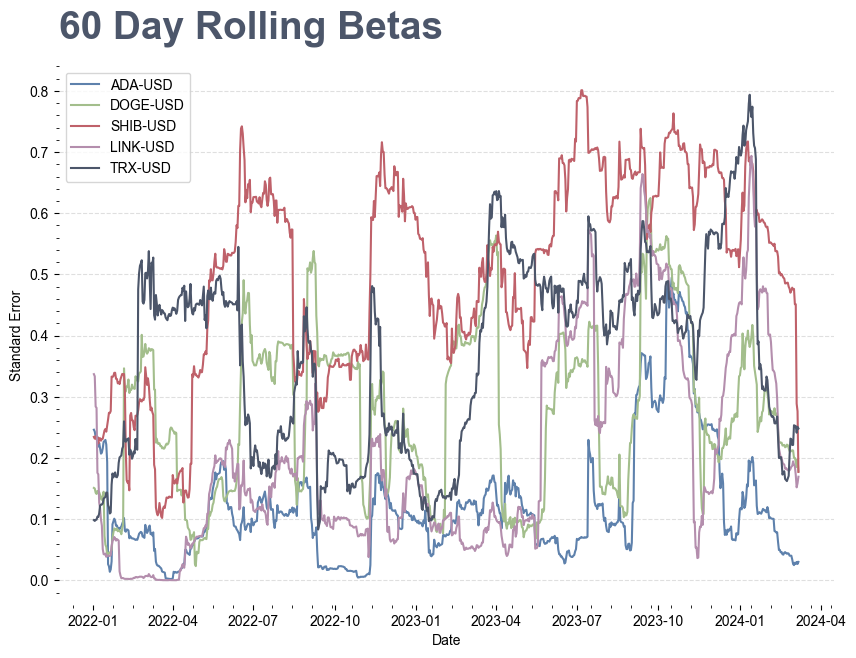

In [ ]:
plot_multiline_chart([(dates[:-59], rb.p_value, f"{ticker}") for ticker, rb in rolling_betas_all_60.items()], title="60 Day Rolling Betas", x_label="Date", y_label="Standard Error")

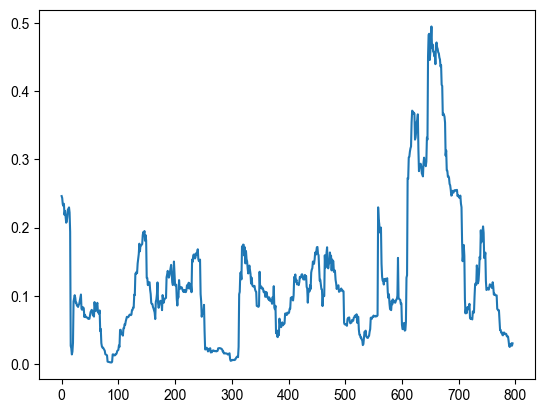

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rolling_betas_all_60['ADA-USD'].p_value.flatten())

In [ ]:
import numpy as np
import statsmodels.api as sm

def linear_regression(x, y):
    # Add constant to independent variable
    x_with_const = sm.add_constant(x)
    
    # Fit linear regression model
    model = sm.OLS(y, x_with_const)
    results = model.fit()
    
    # Extract slope, intercept, and p-value
    slope = results.params[1]
    intercept = results.params[0]
    p_value = results.pvalues[1]
    standard_error = results.bse[1]
    return results

m = linear_regression(market_returns_all[0:60], time_series[0].data['Returns'].to_numpy()[0:60])
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     79.62
Date:                Sun, 05 May 2024   Prob (F-statistic):           1.78e-12
Time:                        23:32:17   Log-Likelihood:                 120.41
No. Observations:                  60   AIC:                            -236.8
Df Residuals:                      58   BIC:                            -232.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.004     -0.458      0.649      -0.011       0.007
x1             1.0638      0.119      8.923      0.000       0.825       1.302
==============================================================================
Omnibus:                       55.960   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.288
Skew:                           2.507   Prob(JB):                     8.63e-77
Kurtosis:                      13.722   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
rolling_betas_all_60['ADA-USD'].standard_error[0]

AttributeError: 'Beta' object has no attribute 'standard_error'